In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

In [26]:
mu, sigma = 2, 0.5 # mean and standard deviation
s = 0.25 + np.random.lognormal(mu, sigma)	
# sawtooth_time = np.linspace(0, 1, 1+int(s))
sawtooth_time = np.arange(start=0, stop=1, step=1/s)
sawtooth_time = (1-sawtooth_time[-1])/2 + sawtooth_time
triangle = (np.pi/2)*(1+sawtooth(2 * np.pi * sawtooth_time,  width = 0.5))

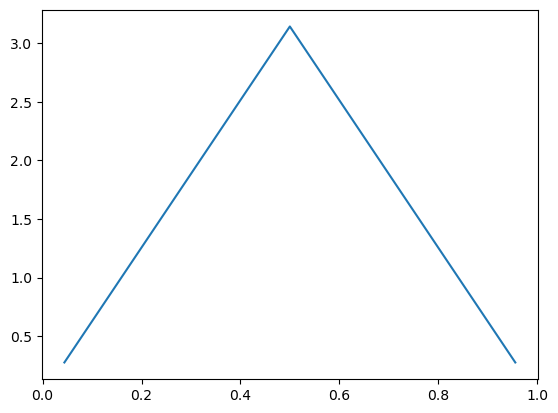

In [27]:
plt.plot(sawtooth_time, triangle)

In [4]:
np.arange(start=0, stop=1, step=0.12)

array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96])

In [478]:
def ReLU(x):
    return x * (x > 0)

def ou(tau, sig, t, y0=0, mode = 'regular'):
		# Purpose: Ornstein-Uhlenbeck noise
		dt=t[1]-t[0]
		sqrtdt = np.sqrt(dt)
		y=np.zeros(t.shape)
		y[0]=y0
		wt=sqrtdt*np.random.normal(size=t.shape)
		for i in range(len(t)-1):
			if mode == 'regular':
				y[i+1]=y[i] + (-y[i]*dt + sig*wt[i])/tau
			elif mode == 'signed':
				y[i+1]=y[i] + (-np.sign(y[i])*dt + sig*wt[i])/tau
		return y

def cast_to(theta):
	return (theta+ np.pi)%(2*np.pi) - np.pi

def calc_direction(v, x):
	xmean = np.mean(v * np.cos(x))
	ymean = np.mean(v * np.sin(x))
	return np.arctan2(ymean, xmean)

In [479]:
# Function for ringrhs
def ringrhs(v, Wmat, tau, g, N, input):
	recurr = (2 * g / N) * np.dot(Wmat, v)
	nonlin = ReLU(recurr + input)
	dydt = (-v + nonlin) / tau
	return dydt

In [496]:
# Initialize parameters
N = 12

g = 2.75 # scales the strength of recurrence
tau = 5 # time scale
epsilon = 1 # anisotropy of input
amp = 5.0 # scales strength of input
thetaG = np.pi/2 # true goal direction

# Construct Wrow
Wrow = np.cos(np.arange(N) * 2 * np.pi / N)

# alpha, beta, D = 2.0, 1.0, 0.3
# Wrow = -beta*np.ones(N)
# Wrow[:2] = Wrow[:2] + [alpha - 2*D, D]
# Wrow[-1] = Wrow[-1] + D

# alpha, beta, D = 2.0, 1.0, 0.3
# Wrow = D*np.cos(np.arange(N) * 2 * np.pi / N)
# Wrow = ReLU(Wrow) - beta
# Wrow[0] += alpha

# Construct Wmat
Wmat = np.array([np.roll(Wrow, n) for n in range(N)])

# Time parameters
tfinal = 500
dt = 0.01

# OU params
tau_m = 0.65
sig_m = 0.45


In [497]:
# print(np.sum(Wmat - Wmat.T))
eig, evec = np.linalg.eigh(Wmat)
print('Largest eigenvalue:', (2 * g / N)*np.max(eig))

Largest eigenvalue: 2.75


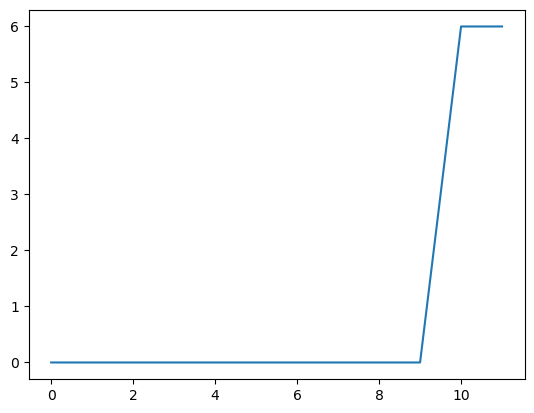

In [498]:
plt.plot(eig)

In [499]:
x = np.linspace(-np.pi, np.pi, N, endpoint=False).reshape(-1, 1)

time = np.linspace(0, tfinal, num = int(tfinal/dt)+1)

# Randomize initial direction
th = np.random.uniform(low=-np.pi, high=np.pi)
headings = [th]

angvel = ou(tau_m, sig_m, time)

# initialize v
# v = amp * (1.0 + epsilon * (np.cos(x - theta0) - 1))
v = amp * (1.0 + epsilon * (np.cos(x - th)))
v = np.zeros_like(x)

goals = [calc_direction(v,x)]
levels = [np.average(v)]

In [500]:
for i in range(len(time)-1):
    input = amp * (1.0 + epsilon * (np.cos(x - th))) * ReLU(np.cos(th - thetaG))
    v = v + dt * ringrhs(v, Wmat, tau, g, N, input)
    th = th + dt*angvel[i]
    

    headings.append(th)
    goals.append(calc_direction(v,x))
    levels.append(np.average(v))

headings = cast_to(np.array(headings))
goals = np.array(goals)
levels = np.array(levels)

0.9121698556976539


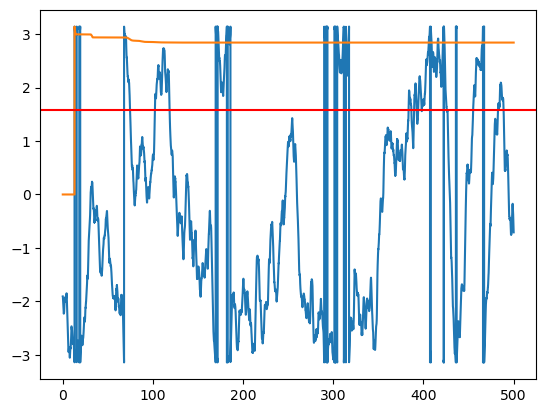

In [501]:
skip = int(100/dt)
dev = np.average(np.sin(goals[skip:]-thetaG)**2)
plt.plot(time, headings)
plt.plot(time, goals)
plt.axhline(thetaG, color='red')
print(dev)

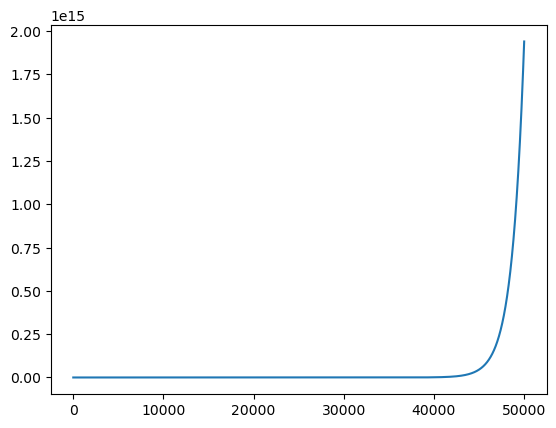

In [502]:
plt.plot(levels)

In [391]:
print(np.sum(Wmat - Wmat.T))
eig, evec = np.linalg.eigh(Wmat)
print('Largest eigenvalue:', (2 * g / N)*np.max(eig))

1.232595164407831e-32
Largest eigenvalue: 0.8660254037844388


In [507]:
yu = np.random.uniform(low=-np.pi, high=np.pi, size=1000000)
yu2 = np.average(np.cos(yu)**2)
yu2
